# Ensemble Methods: Random Forest Tutorial
## Understanding How Multiple Trees Beat Single Trees

### Overview
In this tutorial, we'll explore Random Forest, one of the most powerful and widely-used ensemble methods. We'll cover:

1. **What is Random Forest?** - The intuition behind combining multiple decision trees
2. **How it works** - Bootstrap sampling and random feature selection
3. **Bias-Variance Trade-off** - How Random Forest reduces variance while maintaining low bias
4. **Practical Implementation** - Step-by-step coding with visualizations
5. **Performance Analysis** - Comparing single trees vs Random Forest

### Key Concepts
- **Bootstrap Aggregation (Bagging)**: Training multiple models on different subsets of data
- **Random Feature Selection**: Each tree sees only a random subset of features
- **Ensemble Voting**: Combining predictions from multiple trees
- **Variance Reduction**: How averaging reduces prediction variance

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_regression, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")
print("✓ NumPy, Matplotlib, Seaborn")
print("✓ Scikit-learn (Random Forest, Decision Trees, metrics)")
print("✓ Pandas")
print("Ready to explore Random Forest!")

Libraries imported successfully!
✓ NumPy, Matplotlib, Seaborn
✓ Scikit-learn (Random Forest, Decision Trees, metrics)
✓ Pandas
Ready to explore Random Forest!


## 1. The Intuition Behind Random Forest

### The Wisdom of Crowds

Imagine you're trying to estimate the number of jellybeans in a jar. You could:
1. **Ask one expert** - might be very good or very wrong
2. **Ask 100 people and average their guesses** - usually much more accurate!

Random Forest applies this same principle to machine learning:
- Instead of one decision tree, use many trees
- Each tree sees a slightly different view of the data
- Combine their predictions by voting (classification) or averaging (regression)

### Why Does This Work?
- **Individual trees are high variance** - small changes in data cause big changes in the tree
- **Averaging reduces variance** - errors from individual trees cancel out
- **Maintains low bias** - trees are still expressive models

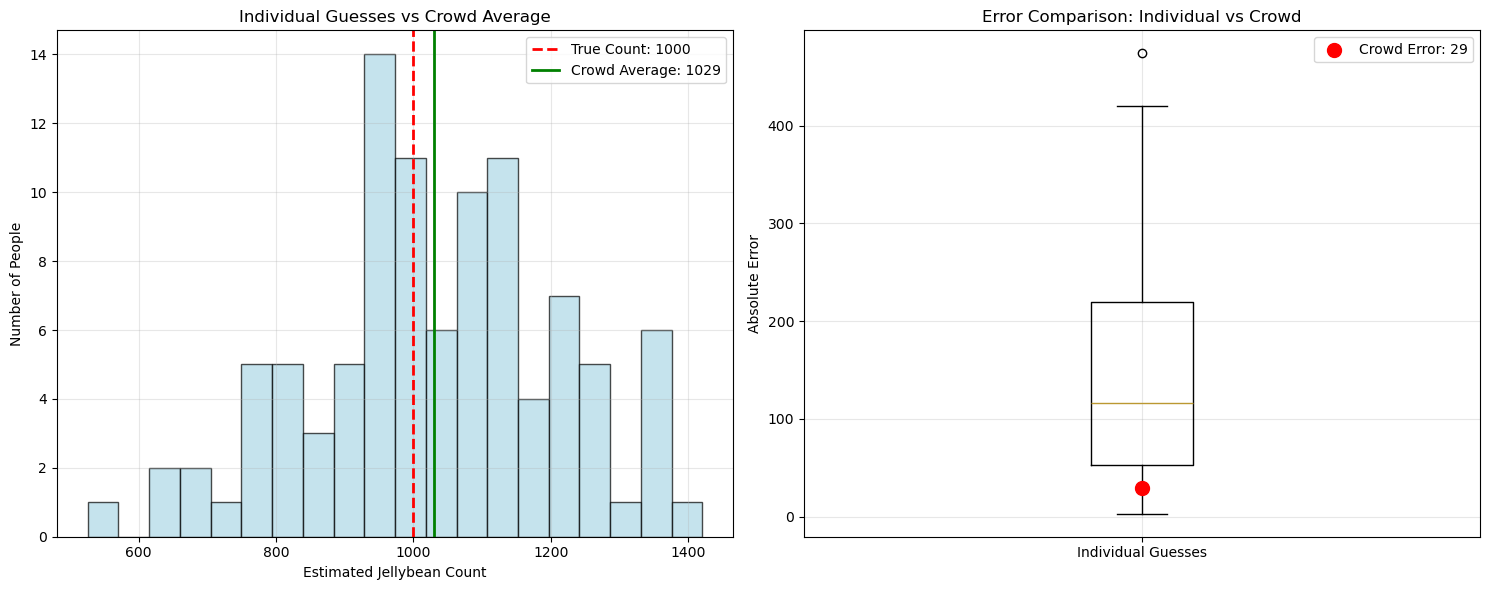

True number of jellybeans: 1000
Average individual error: 144.7
Crowd prediction error: 29.2

Improvement: 5.0x better!


In [2]:
# Let's demonstrate the "wisdom of crowds" with a simple simulation
np.random.seed(42)

# True number of jellybeans
true_count = 1000

# Simulate individual guesses (with some systematic error and random noise)
n_people = 100
individual_guesses = np.random.normal(true_count + 50, 200, n_people)  # Slightly biased estimates

# Calculate crowd average
crowd_average = np.mean(individual_guesses)

# Visualize the concept
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distribution of individual guesses
ax1.hist(individual_guesses, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(true_count, color='red', linestyle='--', linewidth=2, label=f'True Count: {true_count}')
ax1.axvline(crowd_average, color='green', linestyle='-', linewidth=2, label=f'Crowd Average: {crowd_average:.0f}')
ax1.set_xlabel('Estimated Jellybean Count')
ax1.set_ylabel('Number of People')
ax1.set_title('Individual Guesses vs Crowd Average')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error comparison
individual_errors = np.abs(individual_guesses - true_count)
crowd_error = abs(crowd_average - true_count)

ax2.boxplot([individual_errors], labels=['Individual Guesses'])
ax2.scatter([1], [crowd_error], color='red', s=100, label=f'Crowd Error: {crowd_error:.0f}', zorder=5)
ax2.set_ylabel('Absolute Error')
ax2.set_title('Error Comparison: Individual vs Crowd')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"True number of jellybeans: {true_count}")
print(f"Average individual error: {np.mean(individual_errors):.1f}")
print(f"Crowd prediction error: {crowd_error:.1f}")
print(f"\nImprovement: {np.mean(individual_errors)/crowd_error:.1f}x better!")

## 2. How Random Forest Works

### Two Key Ingredients for Diversity

1. **Bootstrap Sampling (Bagging)**
   - Each tree trains on a different random subset of the training data
   - Sampling with replacement (some examples appear multiple times, others not at all)
   - Creates natural diversity between trees

2. **Random Feature Selection**
   - At each split in each tree, only consider a random subset of features
   - Typically √(total features) for classification, total_features/3 for regression
   - Prevents trees from all making the same splits

### The Algorithm
```
For each tree in the forest:
    1. Create bootstrap sample of training data
    2. Train decision tree with random feature selection
    3. Store the trained tree

To make predictions:
    1. Get prediction from each tree
    2. Classification: Vote (majority wins)
    3. Regression: Average the predictions
```

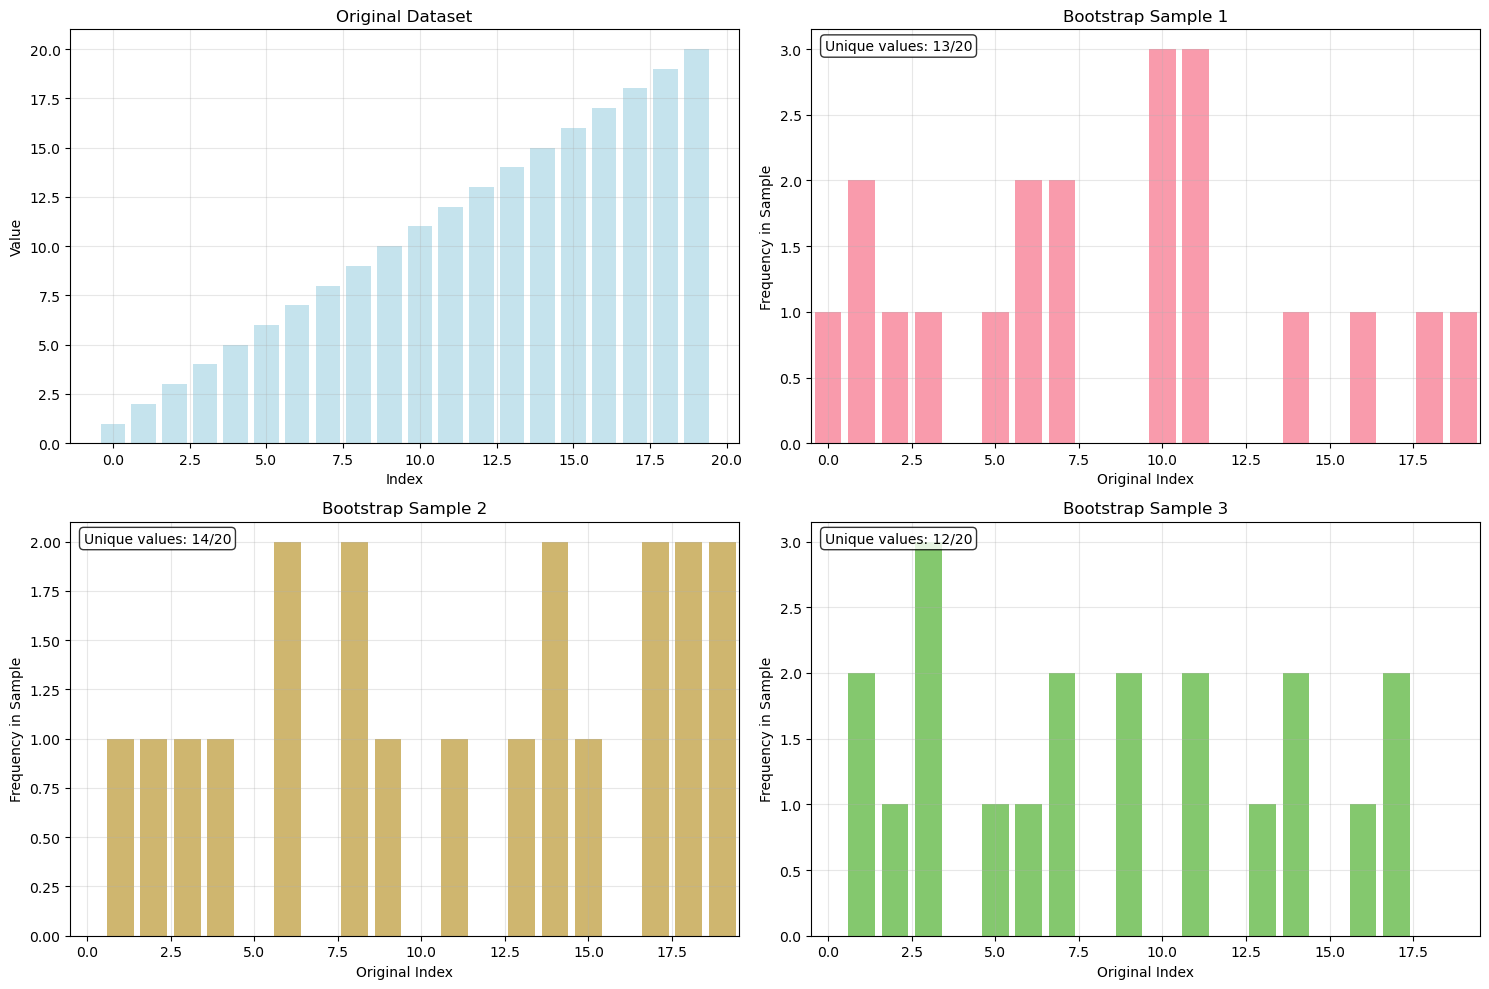

Bootstrap Sampling Observations:
• Each sample has the same size as the original dataset
• Some values appear multiple times, others don't appear at all
• Each sample is different, creating diversity between trees
• On average, each bootstrap sample contains ~63% of unique original examples


In [3]:
# Let's visualize how bootstrap sampling works
np.random.seed(42)

# Create a simple dataset
original_data = np.arange(1, 21)  # Numbers 1-20
n_samples = len(original_data)

# Create 3 bootstrap samples
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original data
axes[0, 0].bar(range(len(original_data)), original_data, alpha=0.7, color='lightblue')
axes[0, 0].set_title('Original Dataset')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# Bootstrap samples
for i in range(3):
    row = (i + 1) // 2
    col = (i + 1) % 2
    
    # Create bootstrap sample
    bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
    bootstrap_sample = original_data[bootstrap_indices]
    
    # Count frequency of each value
    unique_values, counts = np.unique(bootstrap_sample, return_counts=True)
    
    # Plot
    axes[row, col].bar(unique_values - 1, counts, alpha=0.7, color=f'C{i}')
    axes[row, col].set_title(f'Bootstrap Sample {i+1}')
    axes[row, col].set_xlabel('Original Index')
    axes[row, col].set_ylabel('Frequency in Sample')
    axes[row, col].set_xlim(-0.5, 19.5)
    axes[row, col].grid(True, alpha=0.3)
    
    # Show some statistics
    unique_count = len(np.unique(bootstrap_sample))
    axes[row, col].text(0.02, 0.95, f'Unique values: {unique_count}/{n_samples}', 
                       transform=axes[row, col].transAxes, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("Bootstrap Sampling Observations:")
print("• Each sample has the same size as the original dataset")
print("• Some values appear multiple times, others don't appear at all")
print("• Each sample is different, creating diversity between trees")
print("• On average, each bootstrap sample contains ~63% of unique original examples")

## 3. Random Forest vs Single Decision Tree

Let's create a practical example to see Random Forest in action and understand how it reduces variance.

In [4]:
# Create a classification dataset with some complexity
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=2,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Dataset created:")
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Classes: {np.unique(y)} (balanced: {Counter(y)})")

# Train models
print("\nTraining models...")

# Single Decision Tree
single_tree = DecisionTreeClassifier(random_state=42, max_depth=10)
single_tree.fit(X_train, y_train)

# Random Forest
random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
random_forest.fit(X_train, y_train)

# Make predictions
tree_pred = single_tree.predict(X_test)
forest_pred = random_forest.predict(X_test)

# Calculate accuracies
tree_accuracy = accuracy_score(y_test, tree_pred)
forest_accuracy = accuracy_score(y_test, forest_pred)

print(f"\nResults:")
print(f"Single Decision Tree Accuracy: {tree_accuracy:.4f}")
print(f"Random Forest Accuracy: {forest_accuracy:.4f}")
print(f"Improvement: {forest_accuracy - tree_accuracy:.4f}")

Dataset created:
Training set: 700 samples, 10 features
Test set: 300 samples
Classes: [0 1] (balanced: Counter({np.int64(1): 503, np.int64(0): 497}))

Training models...

Results:
Single Decision Tree Accuracy: 0.8867
Random Forest Accuracy: 0.9400
Improvement: 0.0533


## 4. Visualizing Bias-Variance Trade-off

One of the most important concepts in machine learning is the bias-variance trade-off. Let's see how Random Forest helps with this.

In [5]:
# Create a regression dataset to better visualize bias-variance
np.random.seed(42)

# Generate true function (with some complexity)
def true_function(x):
    return 0.5 * x**3 - 2 * x**2 + x + 1 + np.sin(3*x)

# Create training data
n_train = 100
X_train_reg = np.random.uniform(-2, 2, n_train).reshape(-1, 1)
y_train_reg = true_function(X_train_reg.ravel()) + np.random.normal(0, 0.5, n_train)

# Create test data for evaluation
X_test_reg = np.linspace(-2, 2, 100).reshape(-1, 1)
y_test_true = true_function(X_test_reg.ravel())

# Function to simulate bias-variance by training on multiple datasets
def simulate_bias_variance(model_class, n_simulations=50, **model_params):
    predictions = []
    
    for i in range(n_simulations):
        # Generate new training data with same underlying function
        X_sim = np.random.uniform(-2, 2, n_train).reshape(-1, 1)
        y_sim = true_function(X_sim.ravel()) + np.random.normal(0, 0.5, n_train)
        
        # Train model
        model = model_class(**model_params, random_state=i)
        model.fit(X_sim, y_sim)
        
        # Predict on test set
        y_pred = model.predict(X_test_reg)
        predictions.append(y_pred)
    
    return np.array(predictions)

print("Simulating bias-variance for different models...")
print("This may take a moment...")

# Simulate for single tree and random forest
tree_predictions = simulate_bias_variance(DecisionTreeRegressor, max_depth=8)
forest_predictions = simulate_bias_variance(RandomForestRegressor, n_estimators=50, max_depth=8)

print("Simulation complete!")

Simulating bias-variance for different models...
This may take a moment...
Simulation complete!


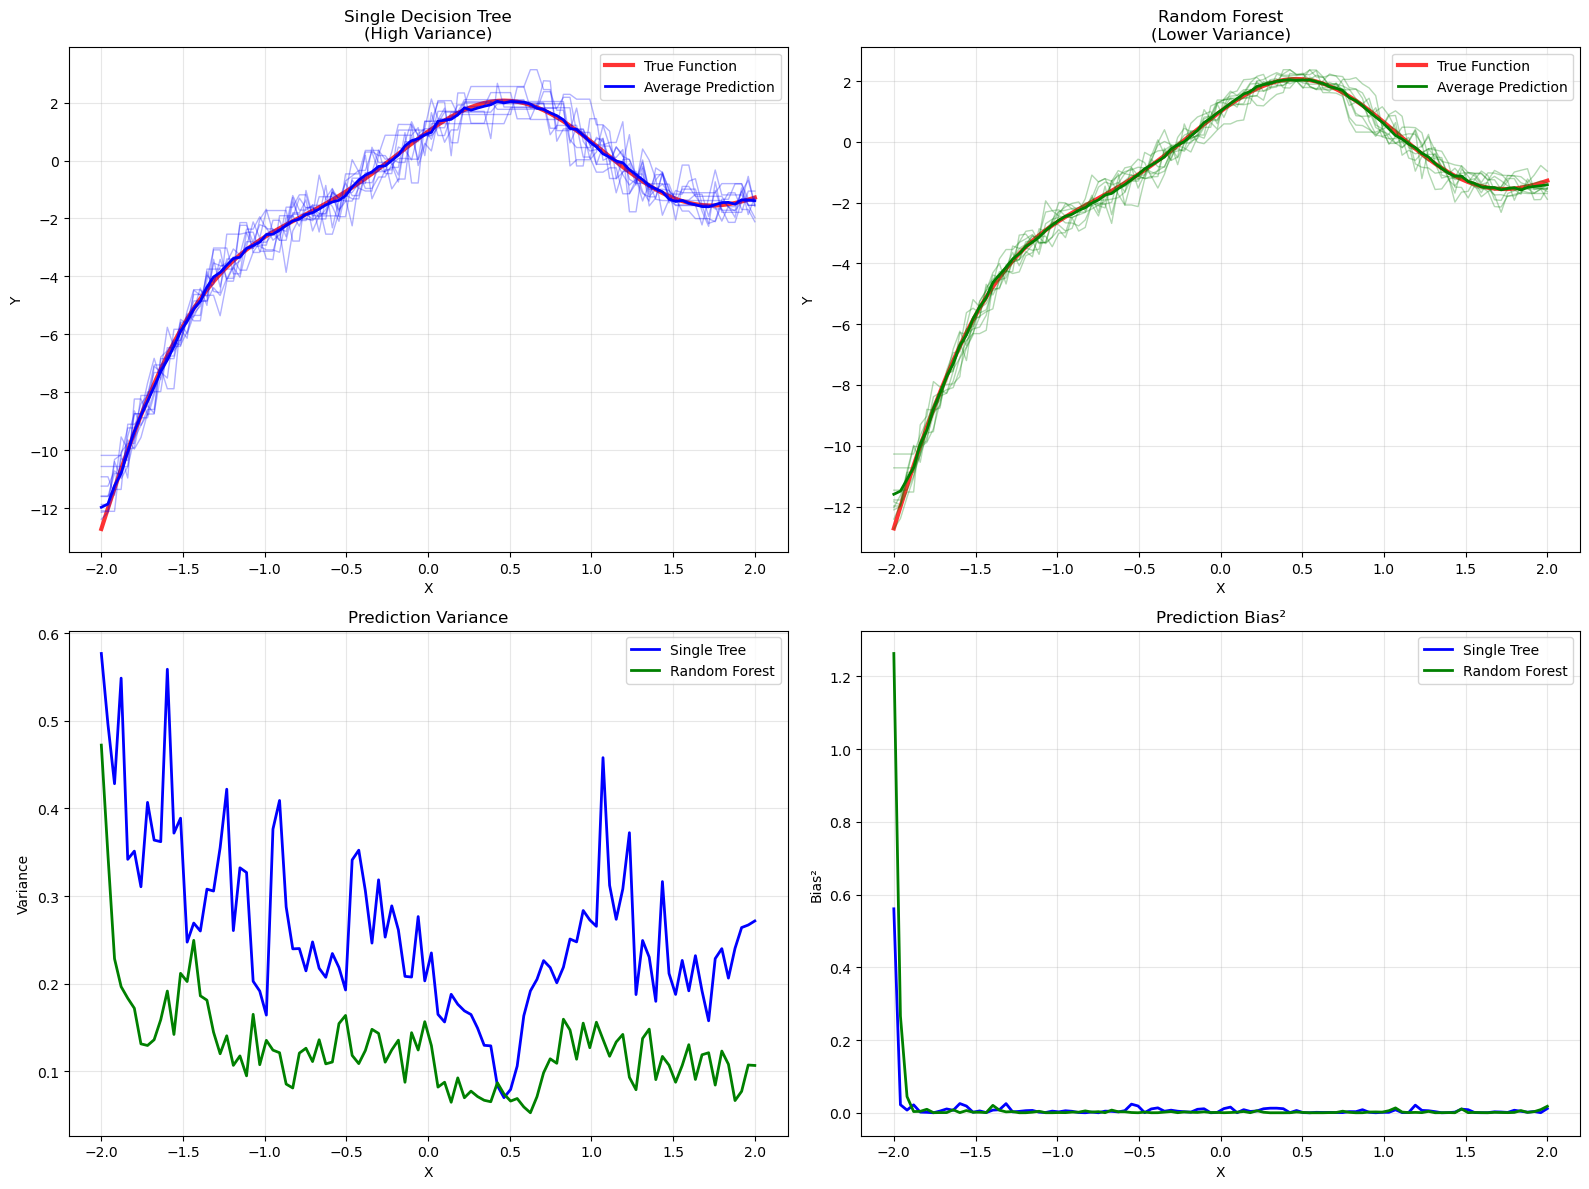

Bias-Variance Analysis:
Single Tree - Mean Variance: 0.2625
Random Forest - Mean Variance: 0.1270
Variance Reduction: 51.6%

Single Tree - Mean Bias²: 0.0111
Random Forest - Mean Bias²: 0.0180
Bias² Change: 61.8%


In [6]:
# Analyze and visualize bias-variance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Calculate bias and variance
tree_mean_pred = np.mean(tree_predictions, axis=0)
tree_var = np.var(tree_predictions, axis=0)
tree_bias_squared = (tree_mean_pred - y_test_true)**2

forest_mean_pred = np.mean(forest_predictions, axis=0)
forest_var = np.var(forest_predictions, axis=0)
forest_bias_squared = (forest_mean_pred - y_test_true)**2

# Plot 1: Single Tree Predictions
axes[0, 0].plot(X_test_reg.ravel(), y_test_true, 'r-', linewidth=3, label='True Function', alpha=0.8)
for i in range(min(10, len(tree_predictions))):
    axes[0, 0].plot(X_test_reg.ravel(), tree_predictions[i], 'b-', alpha=0.3, linewidth=1)
axes[0, 0].plot(X_test_reg.ravel(), tree_mean_pred, 'b-', linewidth=2, label='Average Prediction')
axes[0, 0].set_title('Single Decision Tree\n(High Variance)')
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Random Forest Predictions
axes[0, 1].plot(X_test_reg.ravel(), y_test_true, 'r-', linewidth=3, label='True Function', alpha=0.8)
for i in range(min(10, len(forest_predictions))):
    axes[0, 1].plot(X_test_reg.ravel(), forest_predictions[i], 'g-', alpha=0.3, linewidth=1)
axes[0, 1].plot(X_test_reg.ravel(), forest_mean_pred, 'g-', linewidth=2, label='Average Prediction')
axes[0, 1].set_title('Random Forest\n(Lower Variance)')
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Variance Comparison
axes[1, 0].plot(X_test_reg.ravel(), tree_var, 'b-', linewidth=2, label='Single Tree')
axes[1, 0].plot(X_test_reg.ravel(), forest_var, 'g-', linewidth=2, label='Random Forest')
axes[1, 0].set_title('Prediction Variance')
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Variance')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Bias Comparison
axes[1, 1].plot(X_test_reg.ravel(), tree_bias_squared, 'b-', linewidth=2, label='Single Tree')
axes[1, 1].plot(X_test_reg.ravel(), forest_bias_squared, 'g-', linewidth=2, label='Random Forest')
axes[1, 1].set_title('Prediction Bias²')
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Bias²')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate overall statistics
print("Bias-Variance Analysis:")
print(f"Single Tree - Mean Variance: {np.mean(tree_var):.4f}")
print(f"Random Forest - Mean Variance: {np.mean(forest_var):.4f}")
print(f"Variance Reduction: {(np.mean(tree_var) - np.mean(forest_var))/np.mean(tree_var)*100:.1f}%")
print(f"\nSingle Tree - Mean Bias²: {np.mean(tree_bias_squared):.4f}")
print(f"Random Forest - Mean Bias²: {np.mean(forest_bias_squared):.4f}")
print(f"Bias² Change: {(np.mean(forest_bias_squared) - np.mean(tree_bias_squared))/np.mean(tree_bias_squared)*100:.1f}%")

## 5. Feature Importance in Random Forest

One of the great advantages of Random Forest is that it provides feature importance scores, helping us understand which features are most useful for prediction.

In [7]:
# Let's use the breast cancer dataset for a more interpretable example
from sklearn.datasets import load_breast_cancer

# Load the dataset
cancer_data = load_breast_cancer()
X_cancer = cancer_data.data
y_cancer = cancer_data.target
feature_names = cancer_data.feature_names

print(f"Breast Cancer Dataset:")
print(f"Samples: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer_data.target_names}")
print(f"\nFirst 10 features: {list(feature_names[:10])}")

# Split the data
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

# Train Random Forest
rf_cancer = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_cancer.fit(X_train_cancer, y_train_cancer)

# Get feature importance
feature_importance = rf_cancer.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Calculate accuracy
cancer_accuracy = rf_cancer.score(X_test_cancer, y_test_cancer)
print(f"\nRandom Forest Accuracy: {cancer_accuracy:.4f}")

Breast Cancer Dataset:
Samples: 569
Features: 30
Classes: ['malignant' 'benign']

First 10 features: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]

Random Forest Accuracy: 0.9357


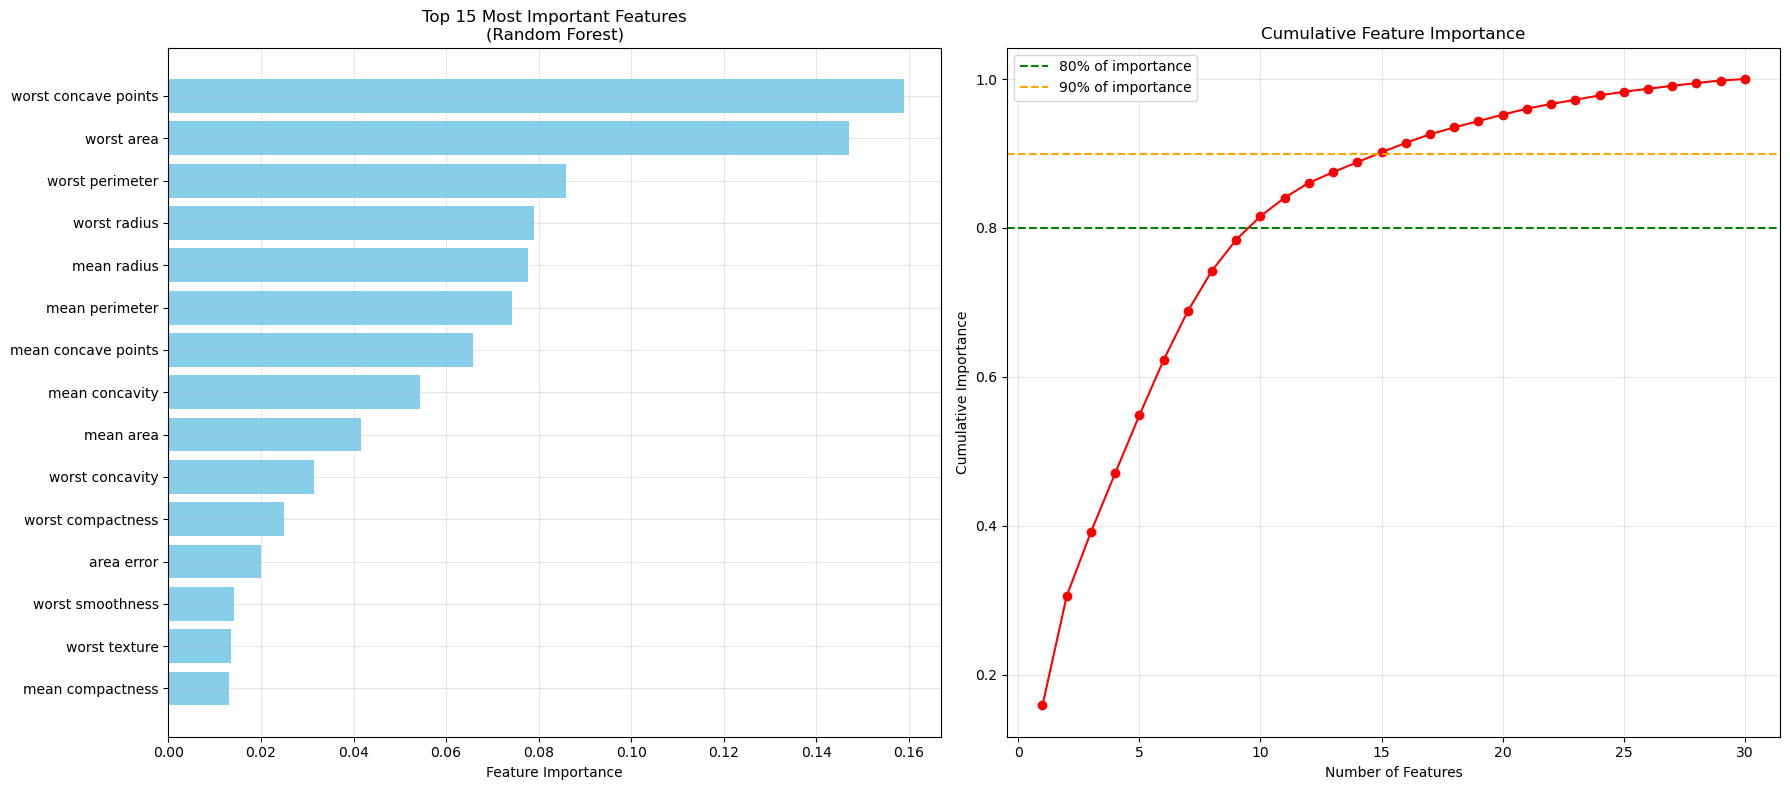


Feature Importance Analysis:
Total features: 30
Features for 80% importance: 10
Features for 90% importance: 15

Top 5 most important features:
  worst concave points: 0.1590
  worst area: 0.1470
  worst perimeter: 0.0858
  worst radius: 0.0790
  mean radius: 0.0777


In [8]:
# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top 15 most important features
top_features = feature_importance_df.head(15)
ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 15 Most Important Features\n(Random Forest)')
ax1.grid(True, alpha=0.3)

# Invert y-axis so most important is at top
ax1.invert_yaxis()

# Plot 2: Cumulative importance
cumulative_importance = np.cumsum(feature_importance_df['importance'])
ax2.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'o-', color='red')
ax2.axhline(y=0.8, color='green', linestyle='--', label='80% of importance')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% of importance')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many features capture 80% and 90% of importance
n_features_80 = np.argmax(cumulative_importance >= 0.8) + 1
n_features_90 = np.argmax(cumulative_importance >= 0.9) + 1

print(f"\nFeature Importance Analysis:")
print(f"Total features: {len(feature_names)}")
print(f"Features for 80% importance: {n_features_80}")
print(f"Features for 90% importance: {n_features_90}")
print(f"\nTop 5 most important features:")
for i, row in feature_importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## 6. Hyperparameter Tuning for Random Forest

Random Forest has several important hyperparameters that can significantly affect performance. Let's explore the most important ones.

In [9]:
# Let's examine how different hyperparameters affect performance
from sklearn.model_selection import validation_curve

# 1. Number of trees (n_estimators)
n_estimators_range = [10, 25, 50, 75, 100, 150, 200]

train_scores_trees, val_scores_trees = validation_curve(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    X_train_cancer, y_train_cancer,
    param_name='n_estimators',
    param_range=n_estimators_range,
    cv=5, scoring='accuracy'
)

# 2. Maximum depth
max_depth_range = [3, 5, 7, 10, 15, 20, None]

train_scores_depth, val_scores_depth = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_cancer, y_train_cancer,
    param_name='max_depth',
    param_range=max_depth_range,
    cv=5, scoring='accuracy'
)

# 3. Maximum features
max_features_range = ['sqrt', 'log2', 0.3, 0.5, 0.7, None]

train_scores_features, val_scores_features = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_cancer, y_train_cancer,
    param_name='max_features',
    param_range=max_features_range,
    cv=5, scoring='accuracy'
)

print("Hyperparameter validation completed!")

Hyperparameter validation completed!


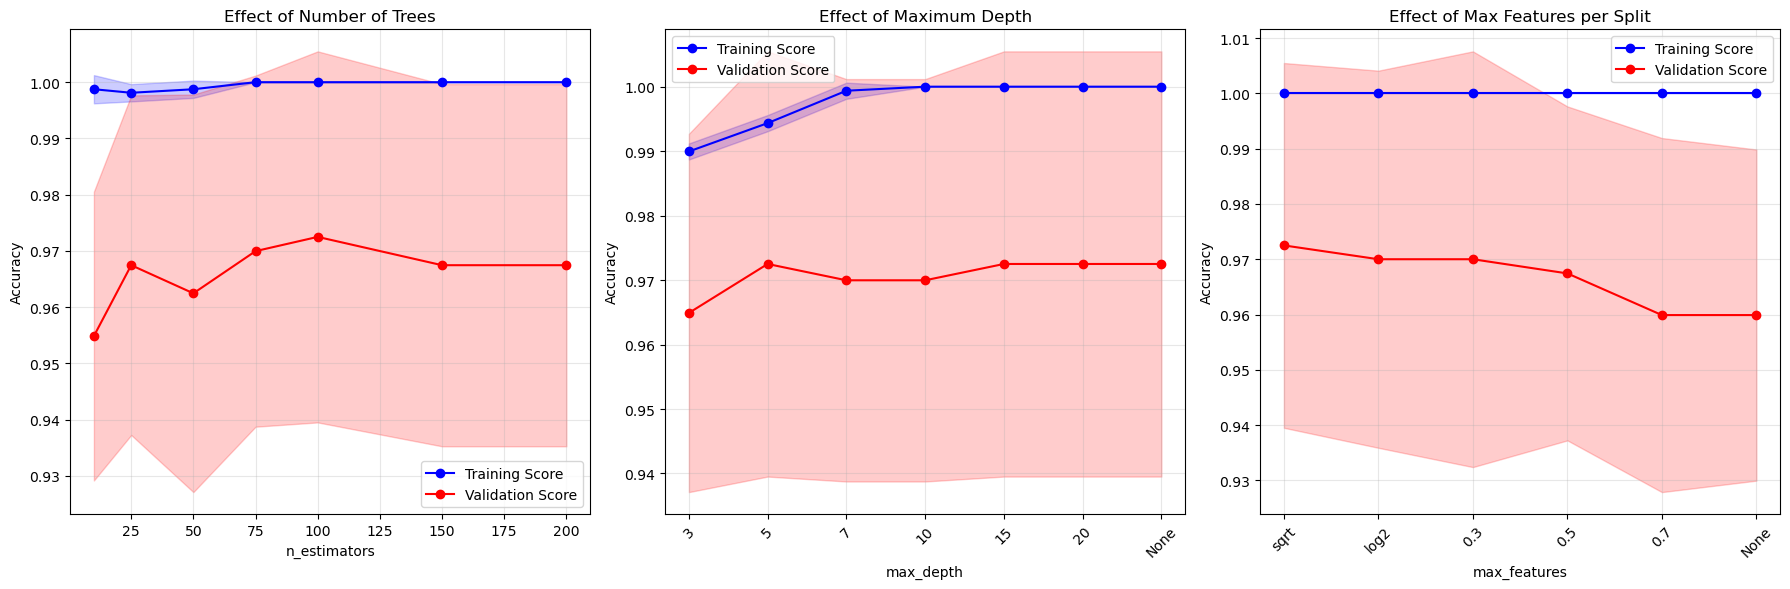


Best Hyperparameters (based on validation score):
n_estimators: 100
max_depth: 5
max_features: sqrt


In [10]:
# Plot the validation curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot validation curve
def plot_validation_curve(ax, param_range, train_scores, val_scores, param_name, title):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Convert param_range to strings if needed
    if param_name == 'max_depth':
        x_labels = [str(x) if x is not None else 'None' for x in param_range]
        x_pos = range(len(param_range))
    elif param_name == 'max_features':
        x_labels = [str(x) for x in param_range]
        x_pos = range(len(param_range))
    else:
        x_labels = param_range
        x_pos = param_range
    
    ax.plot(x_pos, train_mean, 'o-', color='blue', label='Training Score')
    ax.fill_between(x_pos, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    ax.plot(x_pos, val_mean, 'o-', color='red', label='Validation Score')
    ax.fill_between(x_pos, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    if param_name in ['max_depth', 'max_features']:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels, rotation=45)

# Plot 1: Number of estimators
plot_validation_curve(
    axes[0], n_estimators_range, train_scores_trees, val_scores_trees,
    'n_estimators', 'Effect of Number of Trees'
)

# Plot 2: Maximum depth
plot_validation_curve(
    axes[1], max_depth_range, train_scores_depth, val_scores_depth,
    'max_depth', 'Effect of Maximum Depth'
)

# Plot 3: Maximum features
plot_validation_curve(
    axes[2], max_features_range, train_scores_features, val_scores_features,
    'max_features', 'Effect of Max Features per Split'
)

plt.tight_layout()
plt.show()

# Find best parameters
best_n_estimators = n_estimators_range[np.argmax(np.mean(val_scores_trees, axis=1))]
best_max_depth = max_depth_range[np.argmax(np.mean(val_scores_depth, axis=1))]
best_max_features = max_features_range[np.argmax(np.mean(val_scores_features, axis=1))]

print(f"\nBest Hyperparameters (based on validation score):")
print(f"n_estimators: {best_n_estimators}")
print(f"max_depth: {best_max_depth}")
print(f"max_features: {best_max_features}")

## 7. Understanding Individual Trees in the Forest

Let's peek inside the Random Forest to see how individual trees differ from each other.

Analyzing individual trees in the Random Forest...

Tree Analysis:
Tree 1: Accuracy = 0.9064, Top feature = worst concave points
Tree 2: Accuracy = 0.9181, Top feature = worst concavity
Tree 3: Accuracy = 0.9240, Top feature = worst concave points
Tree 4: Accuracy = 0.9064, Top feature = worst radius
Tree 5: Accuracy = 0.9064, Top feature = area error


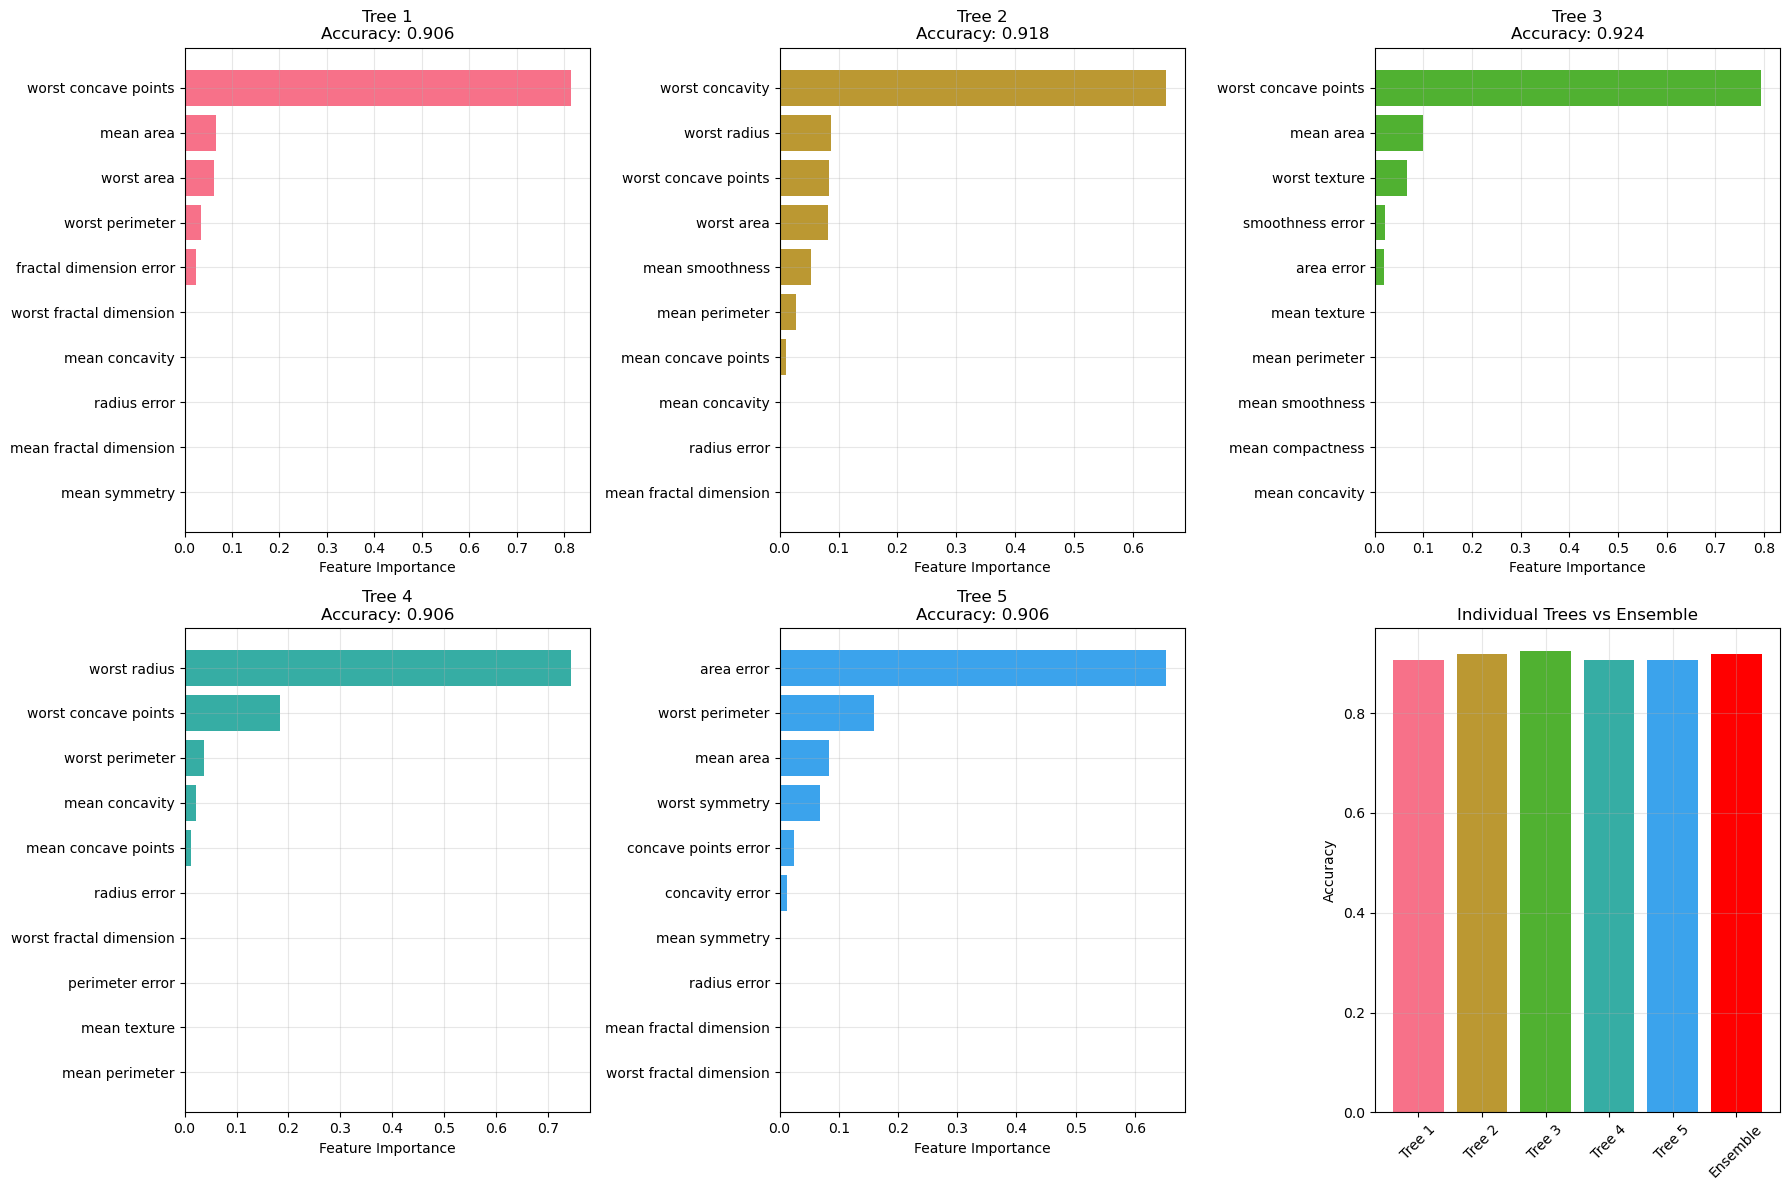


Ensemble Accuracy: 0.9181
Average Individual Tree Accuracy: 0.9123
Ensemble Improvement: 0.0058


In [11]:
# Create a simple Random Forest with fewer trees for visualization
rf_simple = RandomForestClassifier(
    n_estimators=5,
    max_depth=3,
    random_state=42
)
rf_simple.fit(X_train_cancer, y_train_cancer)

# Analyze the diversity of trees
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

print("Analyzing individual trees in the Random Forest...")
print("\nTree Analysis:")

# Look at first 5 trees
for i in range(5):
    tree = rf_simple.estimators_[i]
    
    # Get predictions from individual tree
    tree_pred = tree.predict(X_test_cancer)
    tree_acc = accuracy_score(y_test_cancer, tree_pred)
    
    # Get feature importances for this tree
    tree_importance = tree.feature_importances_
    
    # Plot feature importance for this tree
    top_features_idx = np.argsort(tree_importance)[-10:]  # Top 10 features
    axes[i].barh(range(10), tree_importance[top_features_idx], color=f'C{i}')
    axes[i].set_yticks(range(10))
    axes[i].set_yticklabels([feature_names[j] for j in top_features_idx])
    axes[i].set_xlabel('Feature Importance')
    axes[i].set_title(f'Tree {i+1}\nAccuracy: {tree_acc:.3f}')
    axes[i].grid(True, alpha=0.3)
    
    print(f"Tree {i+1}: Accuracy = {tree_acc:.4f}, Top feature = {feature_names[np.argmax(tree_importance)]}")

# Plot ensemble performance
ensemble_acc = rf_simple.score(X_test_cancer, y_test_cancer)
axes[5].bar(['Tree 1', 'Tree 2', 'Tree 3', 'Tree 4', 'Tree 5', 'Ensemble'], 
           [accuracy_score(y_test_cancer, rf_simple.estimators_[i].predict(X_test_cancer)) for i in range(5)] + [ensemble_acc],
           color=['C0', 'C1', 'C2', 'C3', 'C4', 'red'])
axes[5].set_ylabel('Accuracy')
axes[5].set_title('Individual Trees vs Ensemble')
axes[5].grid(True, alpha=0.3)
axes[5].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nEnsemble Accuracy: {ensemble_acc:.4f}")
individual_accuracies = [accuracy_score(y_test_cancer, rf_simple.estimators_[i].predict(X_test_cancer)) for i in range(5)]
print(f"Average Individual Tree Accuracy: {np.mean(individual_accuracies):.4f}")
print(f"Ensemble Improvement: {ensemble_acc - np.mean(individual_accuracies):.4f}")

## 8. Out-of-Bag (OOB) Score

One unique advantage of Random Forest is the Out-of-Bag (OOB) score, which provides a way to evaluate the model without needing a separate validation set.

Out-of-Bag (OOB) Analysis:
Training Accuracy: 1.0000
OOB Accuracy: 0.9573
Test Accuracy: 0.9357

OOB vs Test difference: 0.0216

Analyzing OOB score vs number of trees...


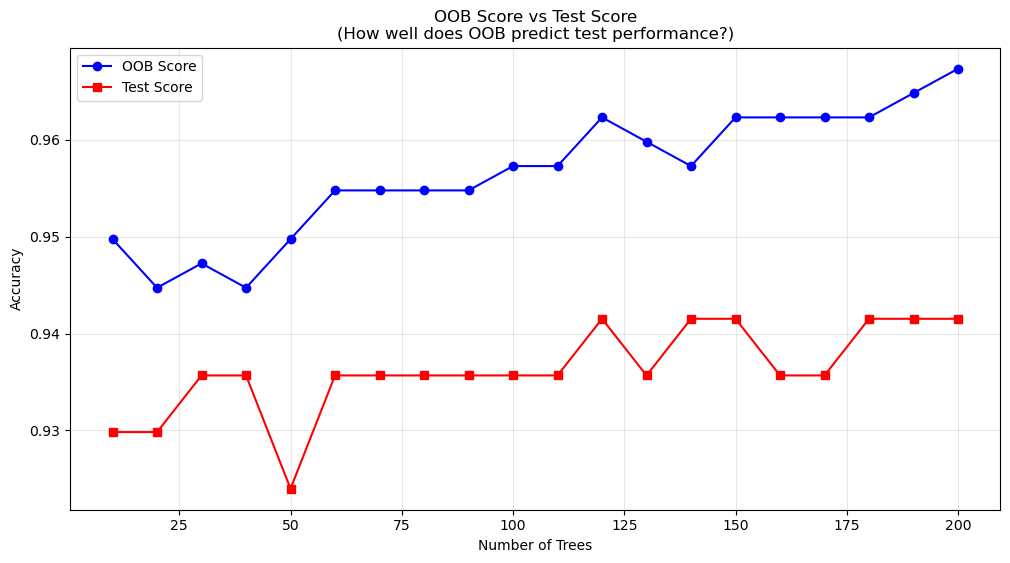

Correlation between OOB and Test scores: 0.6988

Key Insight: OOB score is a good proxy for test performance!
This means you can tune hyperparameters using OOB score without overfitting to test data.


In [12]:
# Train Random Forest with OOB scoring enabled
rf_oob = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_oob.fit(X_train_cancer, y_train_cancer)

# Get various scores
train_score = rf_oob.score(X_train_cancer, y_train_cancer)
test_score = rf_oob.score(X_test_cancer, y_test_cancer)
oob_score = rf_oob.oob_score_

print("Out-of-Bag (OOB) Analysis:")
print(f"Training Accuracy: {train_score:.4f}")
print(f"OOB Accuracy: {oob_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"\nOOB vs Test difference: {abs(oob_score - test_score):.4f}")

# Demonstrate how OOB score changes with number of trees
n_trees_range = range(10, 201, 10)
oob_scores = []
test_scores = []

print("\nAnalyzing OOB score vs number of trees...")
for n_trees in n_trees_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n_trees,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train_cancer, y_train_cancer)
    oob_scores.append(rf_temp.oob_score_)
    test_scores.append(rf_temp.score(X_test_cancer, y_test_cancer))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_trees_range, oob_scores, 'o-', label='OOB Score', color='blue')
plt.plot(n_trees_range, test_scores, 's-', label='Test Score', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('OOB Score vs Test Score\n(How well does OOB predict test performance?)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation between OOB and test scores
correlation = np.corrcoef(oob_scores, test_scores)[0, 1]
print(f"Correlation between OOB and Test scores: {correlation:.4f}")
print(f"\nKey Insight: OOB score is a good proxy for test performance!")
print(f"This means you can tune hyperparameters using OOB score without overfitting to test data.")

## 9. Practical Tips and Best Practices

Let's wrap up with some practical guidelines for using Random Forest effectively.

Class Distribution Analysis:
Training set class distribution: Counter({np.int64(0): 628, np.int64(1): 72})
Test set class distribution: Counter({np.int64(0): 269, np.int64(1): 31})

Training Random Forest models...


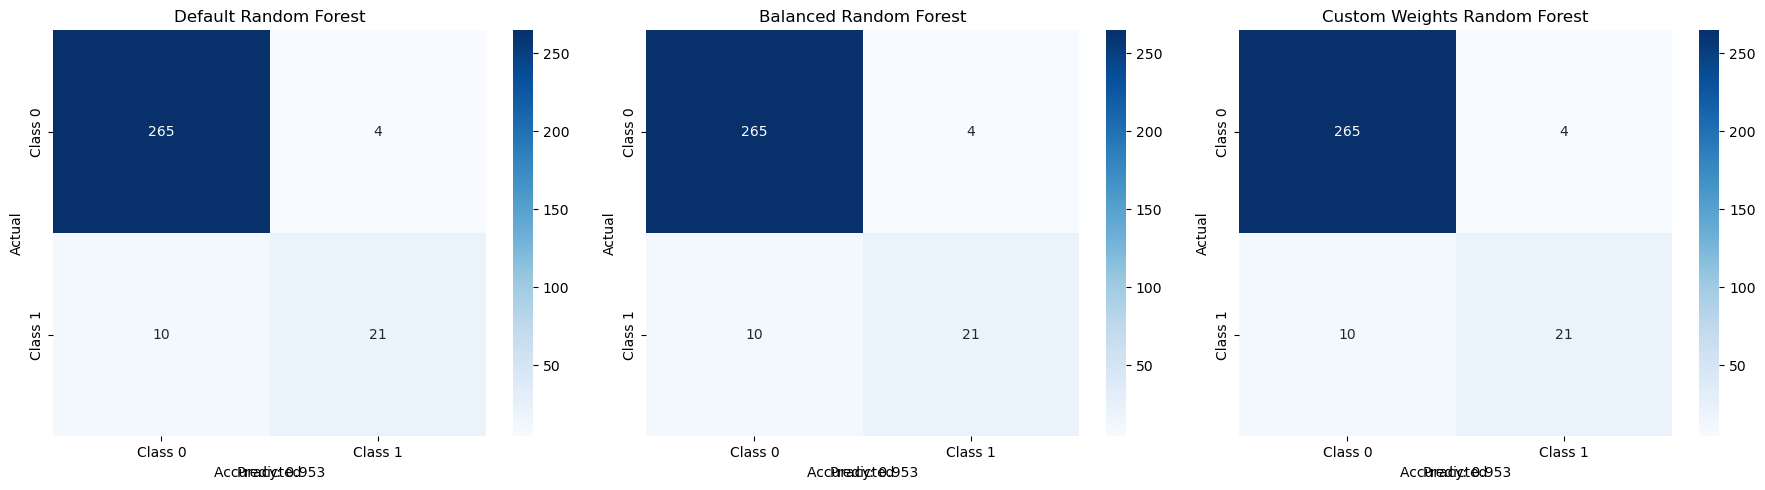


Detailed Classification Reports:

Default Random Forest:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       269
     Class 1       0.84      0.68      0.75        31

    accuracy                           0.95       300
   macro avg       0.90      0.83      0.86       300
weighted avg       0.95      0.95      0.95       300


Balanced Random Forest:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       269
     Class 1       0.84      0.68      0.75        31

    accuracy                           0.95       300
   macro avg       0.90      0.83      0.86       300
weighted avg       0.95      0.95      0.95       300


Custom Weights Random Forest:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       269
     Class 1       0.84      0.68      0.75        31

    accuracy                           0.95       300
   macro avg  

In [13]:
# Demonstrate the effect of class imbalance and how to handle it
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Create an imbalanced dataset
X_imb, y_imb = make_classification(
    n_samples=1000,
    n_features=10,
    n_classes=2,
    weights=[0.9, 0.1],  # 90% class 0, 10% class 1
    random_state=42
)

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=42, stratify=y_imb
)

print("Class Distribution Analysis:")
print(f"Training set class distribution: {Counter(y_train_imb)}")
print(f"Test set class distribution: {Counter(y_test_imb)}")

# Train models with different approaches
print("\nTraining Random Forest models...")

# 1. Default Random Forest
rf_default = RandomForestClassifier(n_estimators=100, random_state=42)
rf_default.fit(X_train_imb, y_train_imb)

# 2. Balanced Random Forest
rf_balanced = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced',
    random_state=42
)
rf_balanced.fit(X_train_imb, y_train_imb)

# 3. Custom class weights
rf_custom = RandomForestClassifier(
    n_estimators=100,
    class_weight={0: 1, 1: 5},  # Give 5x weight to minority class
    random_state=42
)
rf_custom.fit(X_train_imb, y_train_imb)

# Make predictions
pred_default = rf_default.predict(X_test_imb)
pred_balanced = rf_balanced.predict(X_test_imb)
pred_custom = rf_custom.predict(X_test_imb)

# Evaluate models
models = {
    'Default': (rf_default, pred_default),
    'Balanced': (rf_balanced, pred_balanced),
    'Custom Weights': (rf_custom, pred_custom)
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, (model, pred)) in enumerate(models.items()):
    # Create confusion matrix
    cm = confusion_matrix(y_test_imb, pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'],
                ax=axes[i])
    axes[i].set_title(f'{name} Random Forest')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_imb, pred)
    axes[i].text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', 
                transform=axes[i].transAxes, ha='center')

plt.tight_layout()
plt.show()

# Print detailed classification reports
print("\nDetailed Classification Reports:")
for name, (model, pred) in models.items():
    print(f"\n{name} Random Forest:")
    print(classification_report(y_test_imb, pred, target_names=['Class 0', 'Class 1']))

## 10. Summary and Key Takeaways

### What We've Learned About Random Forest

1. **The Power of Ensemble**: Multiple weak learners create a strong learner
2. **Variance Reduction**: Bootstrap sampling + averaging reduces overfitting
3. **Feature Randomness**: Random feature selection increases diversity
4. **Bias-Variance Trade-off**: RF reduces variance while maintaining low bias
5. **Feature Importance**: Built-in feature ranking for interpretability
6. **OOB Scoring**: Free validation without separate data
7. **Robustness**: Handles missing values, outliers, and different data types well

### When to Use Random Forest

**✅ Good for:**
- Tabular data with mixed feature types
- When you need feature importance
- Baseline model (often works well out-of-the-box)
- When interpretability matters (more than neural networks)
- Imbalanced datasets (with proper class weighting)

**❌ Not ideal for:**
- Very high-dimensional sparse data (like text)
- When you need the absolute best performance (consider gradient boosting)
- Real-time prediction with strict latency requirements
- Small datasets (individual trees might be better)

### Key Hyperparameters to Tune

1. **n_estimators**: More trees = better performance (diminishing returns after ~100)
2. **max_depth**: Controls individual tree complexity
3. **max_features**: Controls randomness (√features for classification)
4. **min_samples_split/leaf**: Controls overfitting
5. **class_weight**: Handle imbalanced datasets

Final Algorithm Comparison on Breast Cancer Dataset
Logistic Regression : 0.9807 ± 0.0065
SVM                 : 0.9736 ± 0.0147
K-Nearest Neighbors : 0.9649 ± 0.0096
Decision Tree       : 0.9173 ± 0.0242
Random Forest       : 0.9561 ± 0.0228


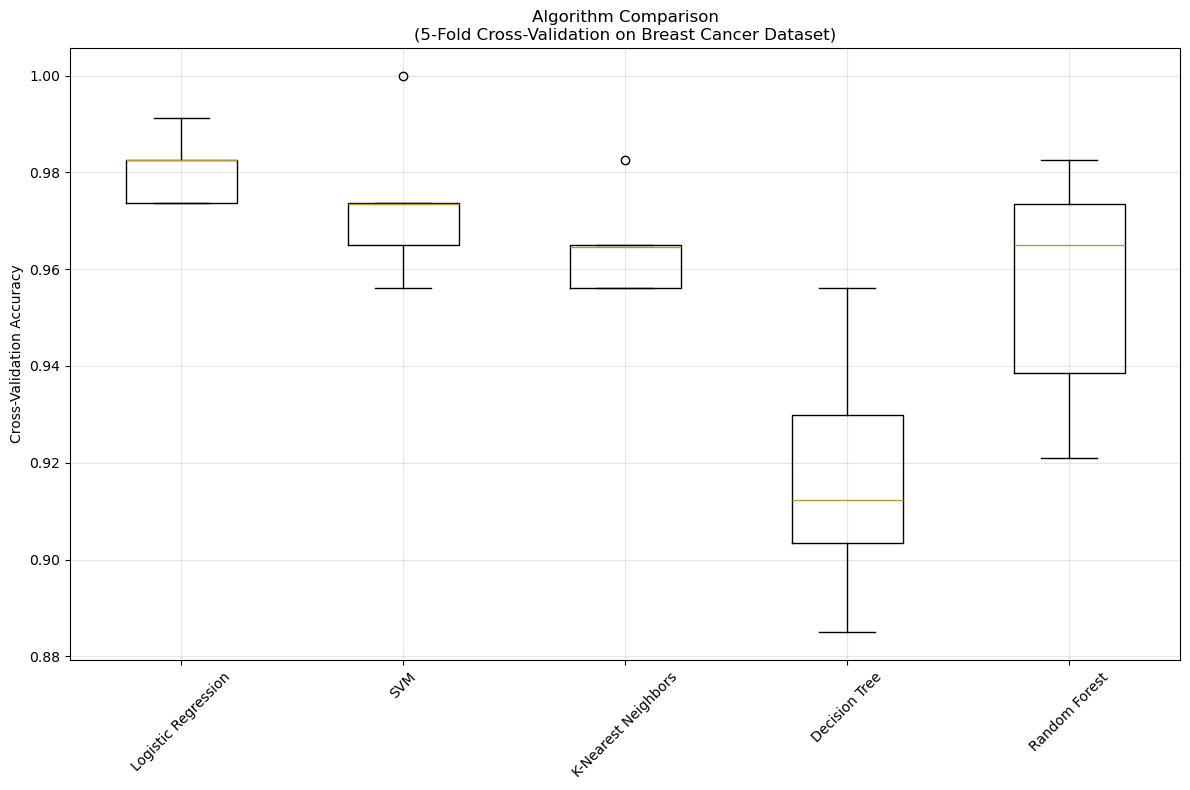


Best performing algorithm: Logistic Regression
Best accuracy: 0.9807 ± 0.0065

CONGRATULATIONS! You've mastered Random Forest!
Key insights gained:
✓ How ensemble methods reduce variance
✓ The importance of bootstrap sampling and feature randomness
✓ Feature importance and model interpretability
✓ Hyperparameter tuning strategies
✓ Handling imbalanced datasets
✓ When to use Random Forest vs other algorithms


In [14]:
# Final comparison: Random Forest vs other common algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

print("Final Algorithm Comparison on Breast Cancer Dataset")
print("=" * 55)

# Define algorithms
algorithms = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Standardize features for algorithms that need it
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

results = {}
for name, model in algorithms.items():
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        # Use scaled features
        scores = cross_val_score(model, X_cancer_scaled, y_cancer, cv=5, scoring='accuracy')
    else:
        # Tree-based models don't need scaling
        scores = cross_val_score(model, X_cancer, y_cancer, cv=5, scoring='accuracy')
    
    results[name] = scores
    print(f"{name:20}: {scores.mean():.4f} ± {scores.std():.4f}")

# Visualize results
plt.figure(figsize=(12, 8))
plt.boxplot([results[name] for name in algorithms.keys()], 
            labels=algorithms.keys())
plt.ylabel('Cross-Validation Accuracy')
plt.title('Algorithm Comparison\n(5-Fold Cross-Validation on Breast Cancer Dataset)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best performing algorithm
best_algorithm = max(results.items(), key=lambda x: x[1].mean())
print(f"\nBest performing algorithm: {best_algorithm[0]}")
print(f"Best accuracy: {best_algorithm[1].mean():.4f} ± {best_algorithm[1].std():.4f}")

print("\n" + "="*60)
print("CONGRATULATIONS! You've mastered Random Forest!")
print("Key insights gained:")
print("✓ How ensemble methods reduce variance")
print("✓ The importance of bootstrap sampling and feature randomness")
print("✓ Feature importance and model interpretability")
print("✓ Hyperparameter tuning strategies")
print("✓ Handling imbalanced datasets")
print("✓ When to use Random Forest vs other algorithms")
print("="*60)